In [ ]:
#retrive data from cds.climate.copernicus 
import cdsapi
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'variable': [
            'geopotential', 'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '200', '500', '700',
            '850',
        ],
        'year': '2016',
        'month': '07',
        'day': [
            '06', '07', '08',
            '09',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            -10, -90, -40,
            -60,
        ],
    },
    'atacama_072016_geopotential_wind_large.grib')

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cfgrib
import cartopy.crs as ccrs
import cartopy
from astropy.constants import g0
import math
import gif

%matplotlib inline

In [2]:
ds = xr.open_dataset('atacama_072016_geopotential_wind_large.grib', engine='cfgrib')

Ignoring index file '/work/rpinto/ERA5/atacama_072016_geopotential_wind_large.grib.90c91.idx' older than GRIB file


In [3]:
ds.head()

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 4, latitude: 5, longitude: 5, time: 5)
Coordinates:
    number         int64 ...
  * time           (time) datetime64[ns] 2016-07-06 ... 2016-07-06T04:00:00
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) int64 850 700 500 200
  * latitude       (latitude) float64 -10.0 -10.25 -10.5 -10.75 -11.0
  * longitude      (longitude) float64 -90.0 -89.75 -89.5 -89.25 -89.0
    valid_time     (time) datetime64[ns] ...
Data variables:
    z              (time, isobaricInhPa, latitude, longitude) float32 ...
    u              (time, isobaricInhPa, latitude, longitude) float32 ...
    v              (time, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-29T20:10:42 GRIB to CDM+CF via cfgrib-0....

In [4]:
print(g0)

  Name   = Standard acceleration of gravity
  Value  = 9.80665
  Uncertainty  = 0.0
  Unit  = m / s2
  Reference = CODATA 2018


In [5]:
# convert the geopotential to geopotential height
args = {'name':'geopotential_height',
        'units': 'm'}
ds['geopot_height'] = ds.z/g0
ds.geopot_height.attrs = args

In [6]:
def wind_direction(u,v):
    '''Compute the wind direction from u and v-components.

    Parameters
    ----------
    u : 1D array or float point
        Wind component in the X (East-West) direction
    v : 1D array or float point
        Wind component in the Y (North-South) direction

    Returns
    -------
    wind direction: 1D array or float point
        Direction of wind towards.
    '''
    wdir = 90 - math.atan2(v,u) * 180/np.pi #must cross check; 270 - math.atan2 for wind direction 'from'
    
    return wdir


def wind_speed_direction(u,v):
    '''Compute the wind speed and direction from u and v-components.

    Parameters
    ----------
    u : 1D array or float point
        Wind component in the X (East-West) direction
    v : 1D array or float point
        Wind component in the Y (North-South) direction

    Returns
    -------
    wind speed: 1D array or float point
        Speed of the wind
    wind direction: 1D array or float point
        Direction of wind towards.
    '''
    speed = np.sqrt(u * u + v * v)
    w_direction = np.vectorize(wind_direction)
    wdir = w_direction(u,v)
    
    return speed, wdir

In [7]:
# compute the wind speed and direction
ws, wdir = wind_speed_direction(ds['u'], ds['v'])

In [8]:
# add the variables to the dataset and assign dimensions and coordiantes
time = ds['time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values
isobar = ds['isobaricInhPa'].values

wspeed = xr.DataArray(ws, coords={'time': time, 
                                  'isobaricInhPa': isobar,
                                  'latitude': lat, 
                                  'longitude': lon
                                 },
             dims=['time', 'isobaricInhPa', 'latitude', 'longitude'])

wdirection = xr.DataArray(wdir, coords={'time': time, 
                                  'isobaricInhPa': isobar,
                                  'latitude': lat, 
                                  'longitude': lon
                                 },
             dims=['time', 'isobaricInhPa', 'latitude', 'longitude'])

In [9]:
# add variable attributes
args1 = {'name':'wind_speed',
        'units': 'm/s'}
args2 = {'name':'wind_direction',
        'units': 'cardinal'}
ds['wind_speed'] = wspeed
ds['wind_direction'] = wdirection
ds.wind_speed.attrs = args1
ds.wind_direction.attrs = args2

In [10]:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:         (isobaricInhPa: 4, latitude: 121, longitude: 121, time: 96)
Coordinates:
    number          int64 0
  * time            (time) datetime64[ns] 2016-07-06 ... 2016-07-09T23:00:00
    step            timedelta64[ns] 00:00:00
  * isobaricInhPa   (isobaricInhPa) int64 850 700 500 200
  * latitude        (latitude) float64 -10.0 -10.25 -10.5 ... -39.5 -39.75 -40.0
  * longitude       (longitude) float64 -90.0 -89.75 -89.5 ... -60.25 -60.0
    valid_time      (time) datetime64[ns] ...
Data variables:
    z               (time, isobaricInhPa, latitude, longitude) float32 14772....
    u               (time, isobaricInhPa, latitude, longitude) float32 -5.320...
    v               (time, isobaricInhPa, latitude, longitude) float32 2.5812...
    geopot_height   (time, isobaricInhPa, latitude, longitude) float32 1506.3...
    wind_speed      (time, isobaricInhPa, latitude, longitude) float32 5.9139...
    wind_direction  (time, isobaricInhPa, latitud

In [11]:
# select pressure level and time-date:hour
i = 200
j ='2016-07-07T16'

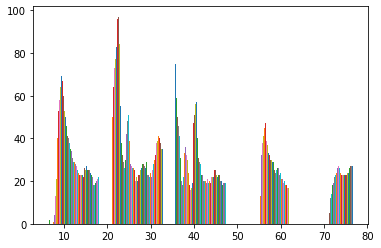

In [12]:
# ascertain how many levels/colour bins required for the contour fill plot for wind speed
plt.hist(ds['wind_speed'].sel(isobaricInhPa = i,time=j).values, bins=5)
plt.show()

In [13]:
@gif.frame
def plot(i,j,ax=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()

    #plot the geopotential height contour lines
    ming = np.min(ds['geopot_height'].sel(isobaricInhPa = i,time=j).values)
    maxg = np.max(ds['geopot_height'].sel(isobaricInhPa = i,time=j).values)
        
    cs = plt.contour(ds.longitude, ds.latitude, ds['geopot_height'].sel(isobaricInhPa = i,time=j),
                     levels=np.arange(ming, maxg, 50), colors='grey')
    cs.clabel(fontsize=12, inline=1, fmt='%.1f')

    #plot the wind speed using contour fill
    colors=["#f7fcf0","#f2faea","#ecf7e5","#e6f5df","#dff3da","#daf1d5","#d5efcf","#d0edc9",
            "#caeac4","#c1e6bf","#b8e3bb","#aedfb7","#a3dcb6","#96d8ba","#8ad3be","#80cec2",
            "#73c9c6","#64c3ca","#58bdce","#50b6d2","#47add0","#3da3cb","#3499c5","#2c8fc0",
            "#2285bb","#167cb7","#0c73b2","#0869ad","#085fa2","#085497","#084a8c","#084081"
           ] # https://react-colorscales.getforge.io/ for color hex codes; cmap='GnBu'
    levels = list(np.arange(0,65,2))
    
    cw = plt.contourf(ds.longitude, ds.latitude, ds['wind_speed'].sel(isobaricInhPa = i,time=j),
                      colors=colors, levels=levels, extend='max')
    plt.colorbar(cw, shrink=0.8, label=r'ms$^{-1}$')
    cw.cmap.set_over("#084081")

    #plot the wind direction as quivers
    coarse_ds = ds.sel(latitude=np.arange(-40, -10, 3), 
                       longitude=np.arange(-90, 60, 3), 
                       method='nearest') # coarser resolution for well-spaced quivers
    wind_speed = coarse_ds['wind_speed'].sel(isobaricInhPa = i,time=j)
    
    plt.quiver(coarse_ds.longitude, coarse_ds.latitude, 
               coarse_ds['u'].sel(isobaricInhPa = i, time=j)/wind_speed, #normalize the wind vectors
               coarse_ds['v'].sel(isobaricInhPa = i, time=j)/wind_speed,
               scale = 1/0.03, #control length of quivers
               pivot = 'mid',
               color = 'k', alpha=0.65)

    plt.title('{}'.format(i) + '-hPa Geopotential Height (m), Wind Speed (m/s),'
              ' and Wind Direction', y=1.05)
    plt.title('Time: {0:.13}'.format(j), loc='right')

    # mark the x,y ticks with latitude and longitude
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=1, linestyle='-')
    gl.xpadding = 35
    gl.ypadding = 35
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False

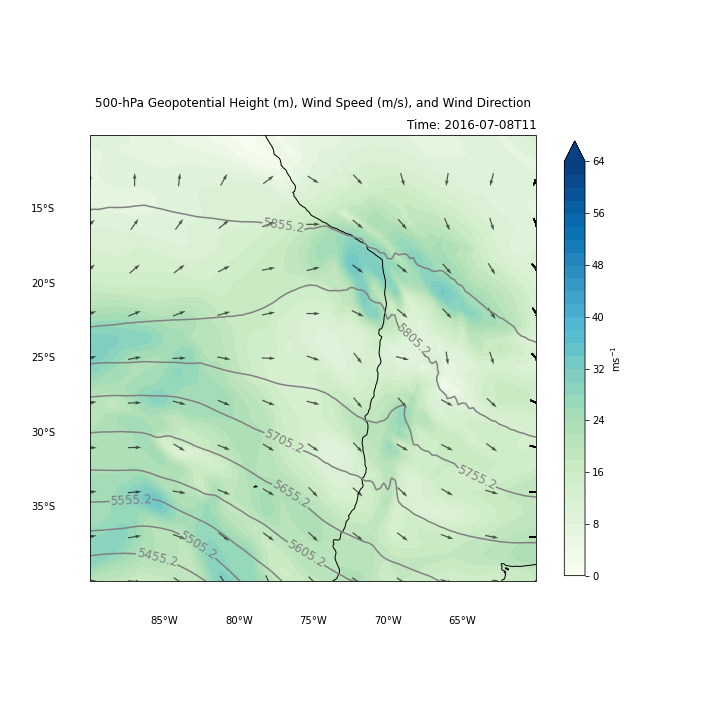

In [14]:
plot(500, '2016-07-08T11')

In [15]:
#animate using gif: https://github.com/maxhumber/gif
gif.options.matplotlib["dpi"] = 300
frames = []
for j in ds.time.values[:7]:
    frame = plot(500, j)
    frames.append(frame)

In [19]:
gif.save(frames, 'example.gif', duration=7, unit="s", between="startend")

In [20]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

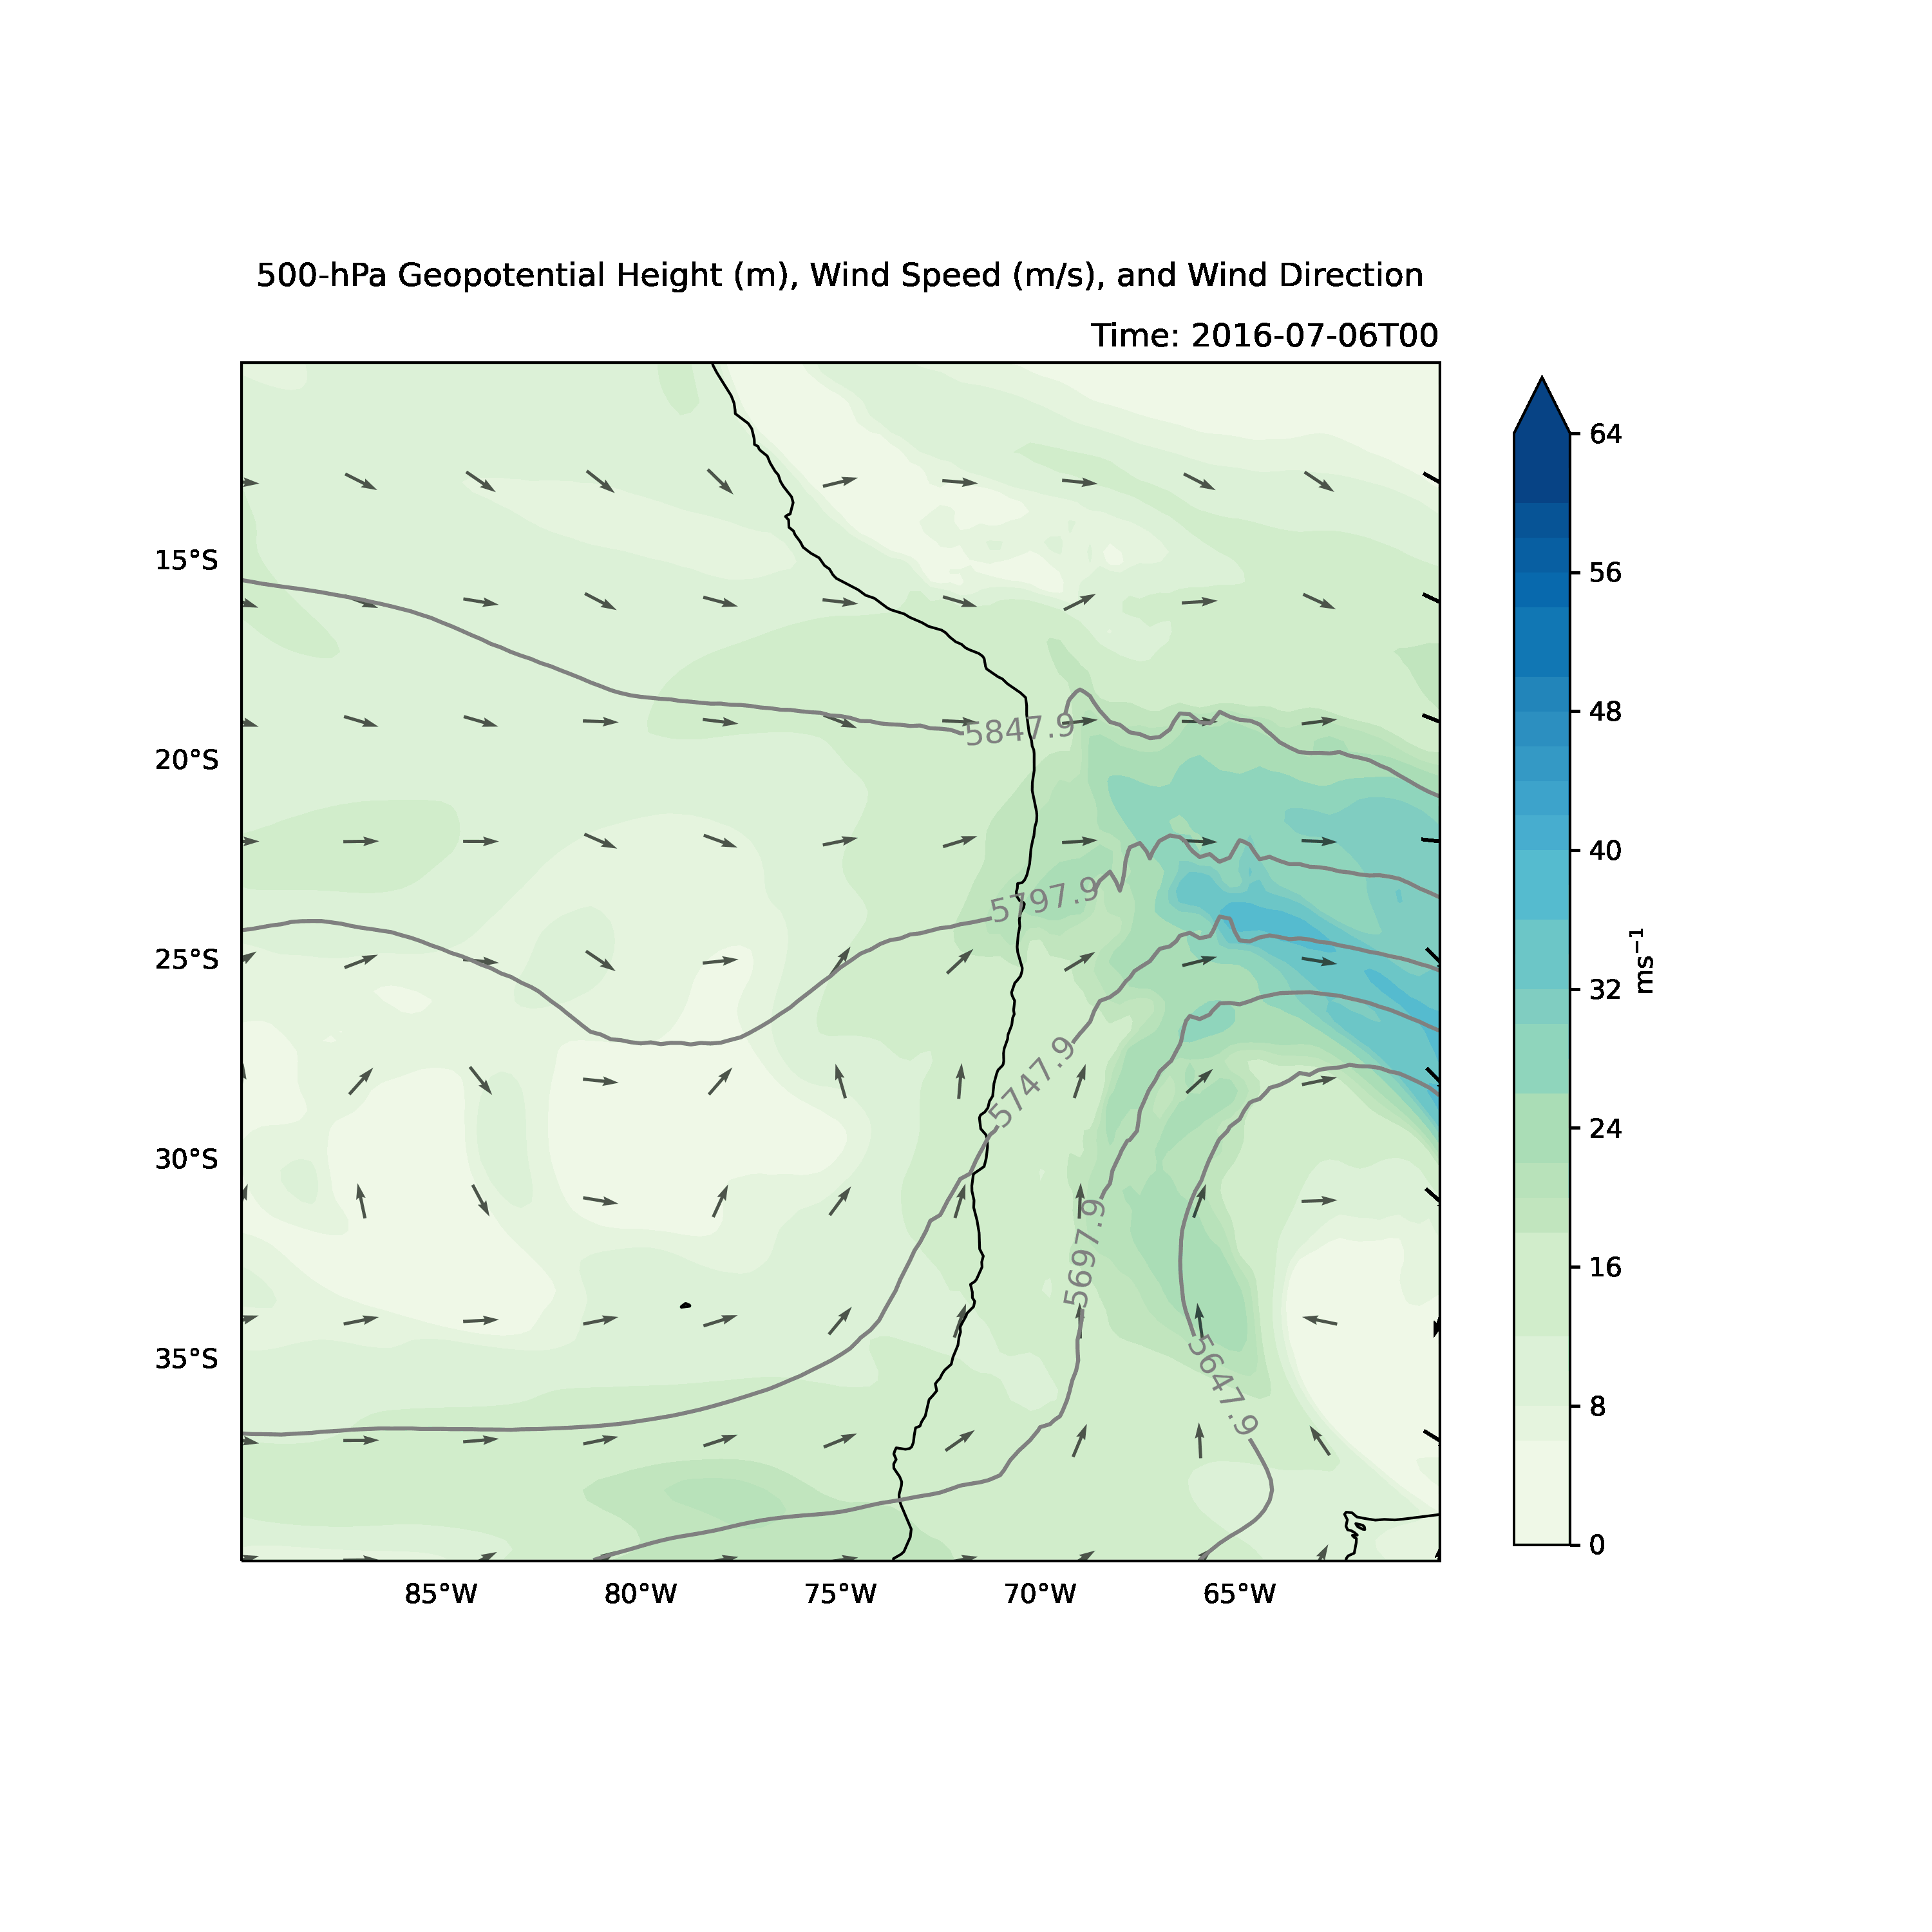

In [21]:
gifPath = Path("example.gif")
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')